In [233]:
import json
import os
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pyproj import CRS, Transformer
from country_bounding_boxes import country_subunits_by_iso_code

In [245]:
# api url string - see https://api.nbnatlas.org/#
url = 'https://records-ws.nbnatlas.org/occurrences/search'

# define parameters for api query
parameters = {
    'q': 'species:Castor fiber',
    'pageSize': 30000
}

# use get request with params
r = requests.get(url, params=parameters)

# convert request to json
j = r.json()

# convert to dataframe using json_normalize
occs = j['occurrences']
df = pd.json_normalize(occs)
df.head()

,uuid,occurrenceID,raw_institutionCode,taxonConceptID,eventDate,occurrenceYear,scientificName,vernacularName,taxonRank,taxonRankID,...,lifeStage,raw_collectionCode,eventDateEnd,raw_vernacularName,recordNumber,locationId,miscDateProperties.occurrence_date_end_dt,vitality,hasUserAssertions,raw_locationRemarks
0,df3817f8-e47a-4f75-81b6-d8b9002571bd,5494,Scottish Beavers,NBNSYS0000005107,1.346717e+12,1325376000000,Castor fiber,Beaver,species,7000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9ed939e1-47f9-44d6-ad93-cb71d09b0378,3816,Scottish Beavers,NBNSYS0000005107,1.283213e+12,1262304000000,Castor fiber,Beaver,species,7000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,764cf1e7-decb-4bff-8245-443360be2302,3761,Scottish Beavers,NBNSYS0000005107,1.281571e+12,1262304000000,Castor fiber,Beaver,species,7000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cefa7bfc-ff18-4ea7-8769-56df5f8b2e49,4928,Scottish Beavers,NBNSYS0000005107,1.311725e+12,1293840000000,Castor fiber,Beaver,species,7000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3165284f-3dcc-403c-9d75-84f5a05de77e,2822,Scottish Beavers,NBNSYS0000005107,1.246925e+12,1230768000000,Castor fiber,Beaver,species,7000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
df.columns

Index(['uuid', 'occurrenceID', 'raw_institutionCode', 'taxonConceptID',
       'eventDate', 'occurrenceYear', 'scientificName', 'vernacularName',
       'taxonRank', 'taxonRankID', 'country', 'kingdom', 'phylum', 'classs',
       'order', 'family', 'genus', 'genusGuid', 'species', 'speciesGuid',
       'stateProvince', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'year', 'month', 'basisOfRecord',
       'raw_occurrenceRemarks', 'left', 'right', 'dataProviderUid',
       'dataProviderName', 'dataResourceUid', 'dataResourceName', 'assertions',
       'speciesGroups', 'geospatialKosher', 'taxonomicKosher', 'collector',
       'collectors', 'raw_scientificName', 'latLong', 'point1', 'point01',
       'point001', 'point0001', 'point00001', 'namesLsid', 'license',
       'identificationVerificationStatus', 'gridReference', 'raw_taxonId',
       'miscStringProperties.identification_qualifier_s',
       'miscStringProperties.occurrence_status_s',
       'miscI

In [248]:
# filter to show Scotland records only
df = df[df['stateProvince']=='Scotland']

In [249]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude']), crs=4326)

gdf = gdf.to_crs(27700)

In [250]:
crs_4326 = CRS.from_epsg(4326)
crs_27700 = CRS.from_epsg(27700)
transformer = Transformer.from_crs(crs_4326, crs_27700, always_xy=True)

In [251]:
scotland_bbox = [c.bbox for c in country_subunits_by_iso_code('GB')][2]

In [252]:
xmin, ymin, xmax, ymax = scotland_bbox

In [253]:
sw = transformer.transform(xmin, ymin)
ne = transformer.transform(xmax, ymax)

In [254]:
xlim, ylim = (sw[0], ne[0]), (sw[1],ne[1])

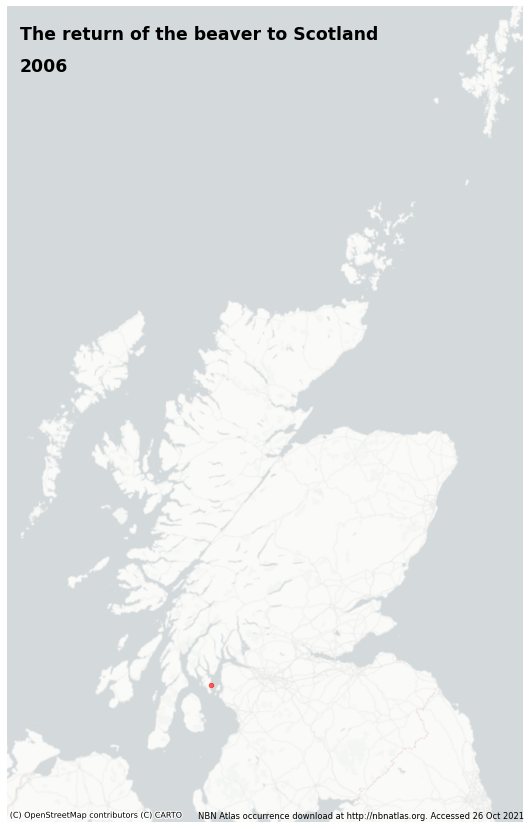

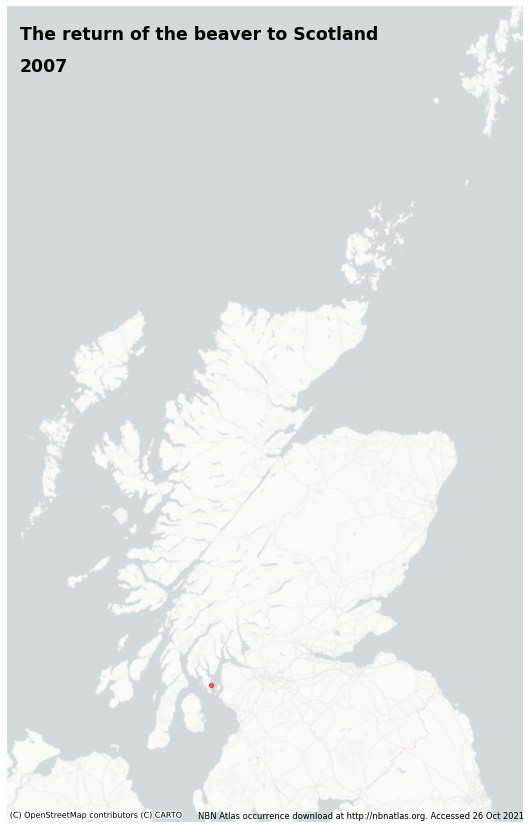

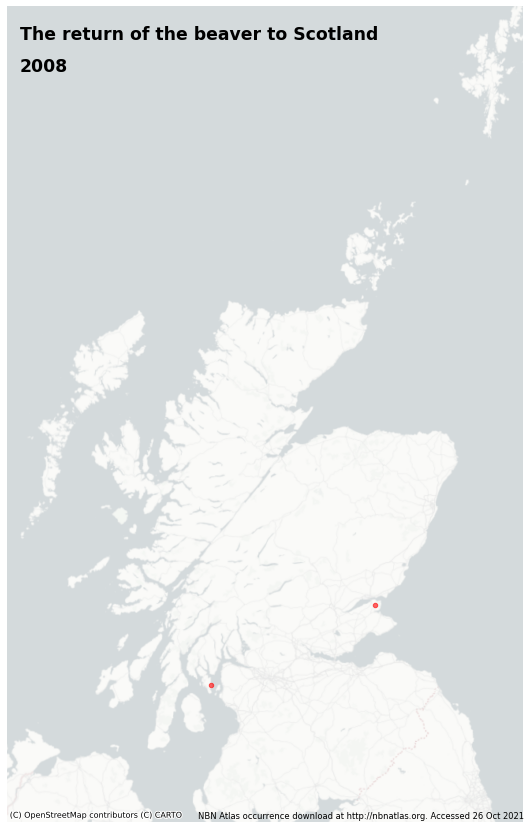

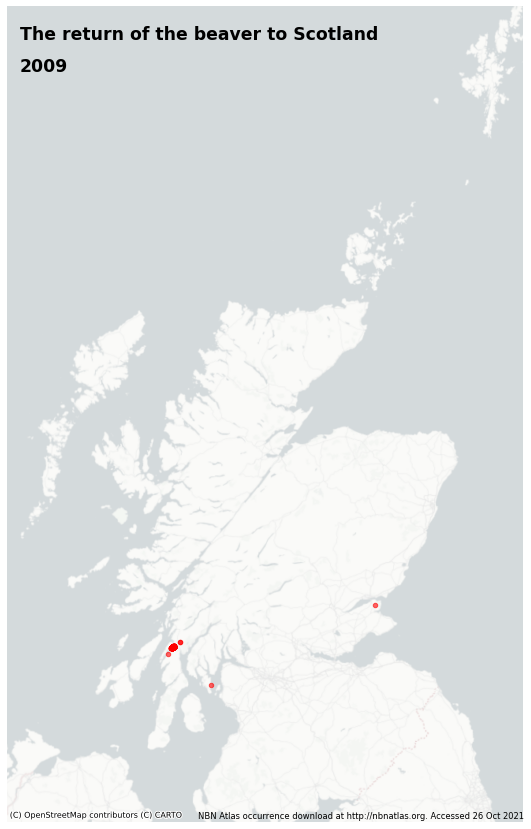

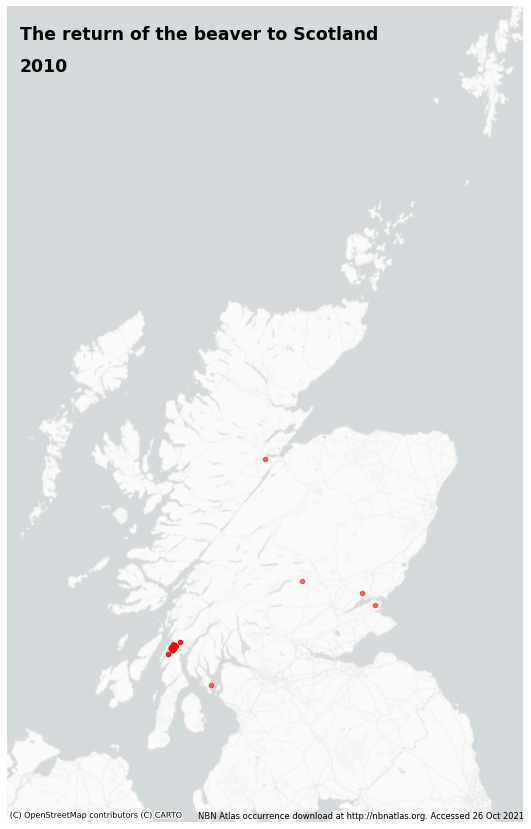

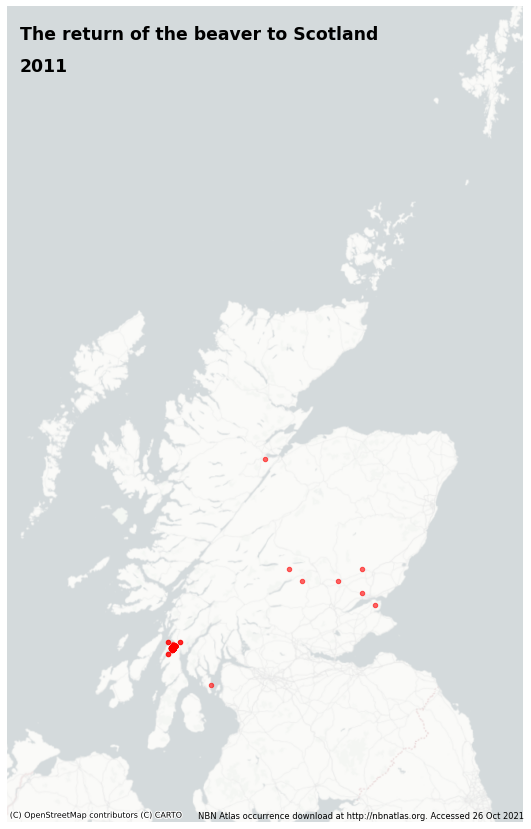

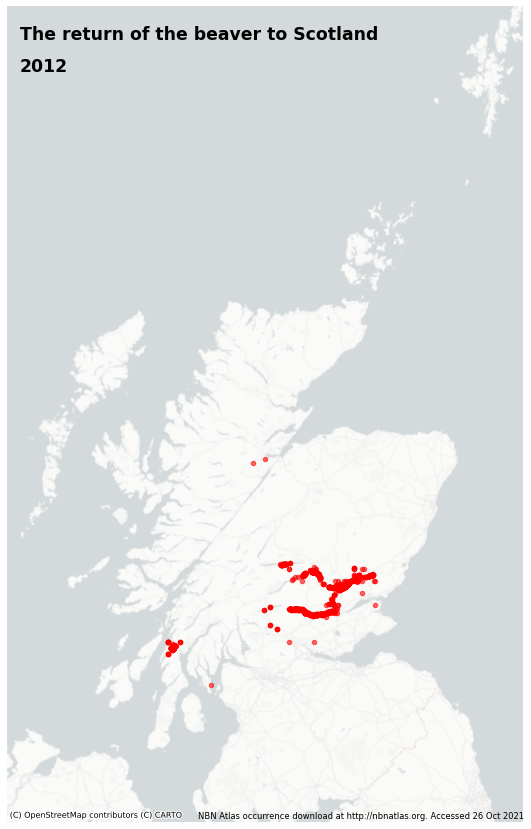

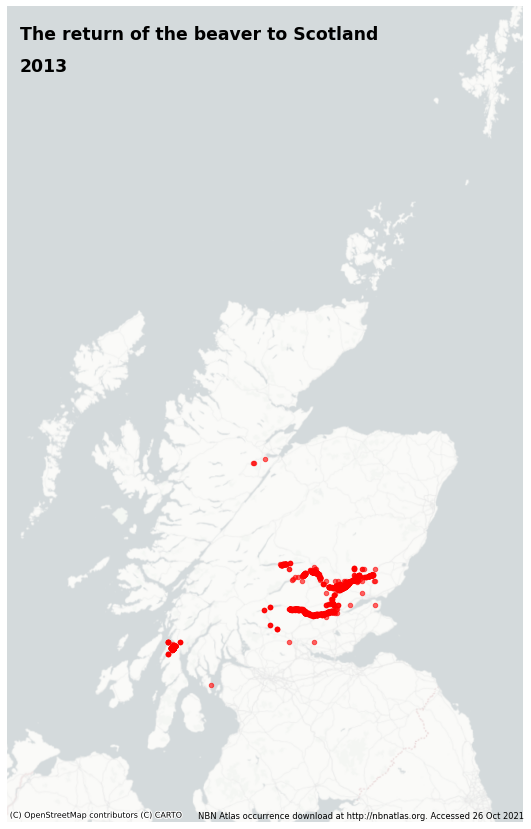

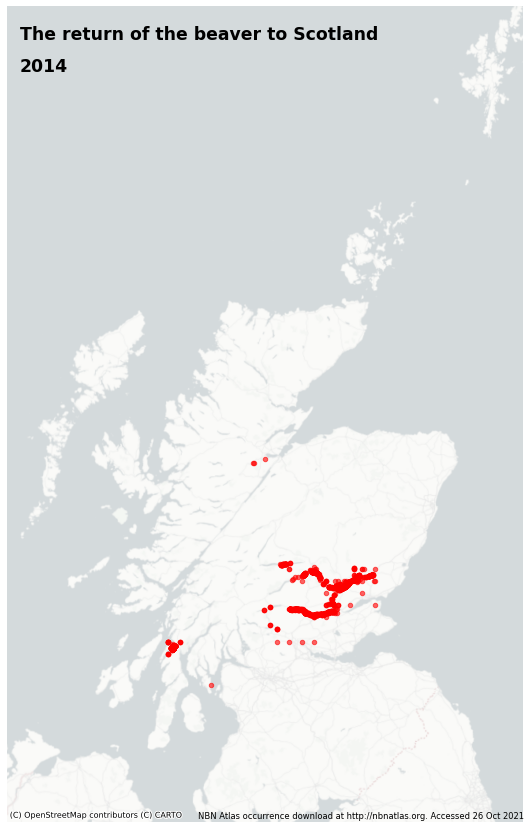

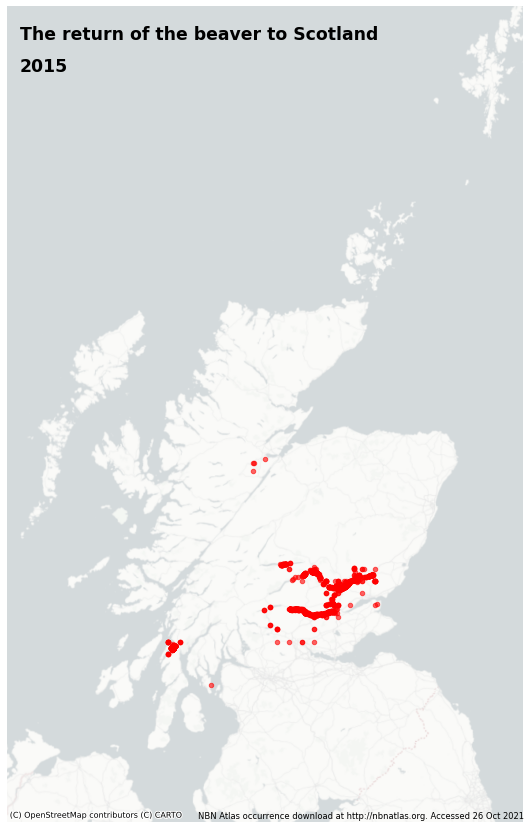

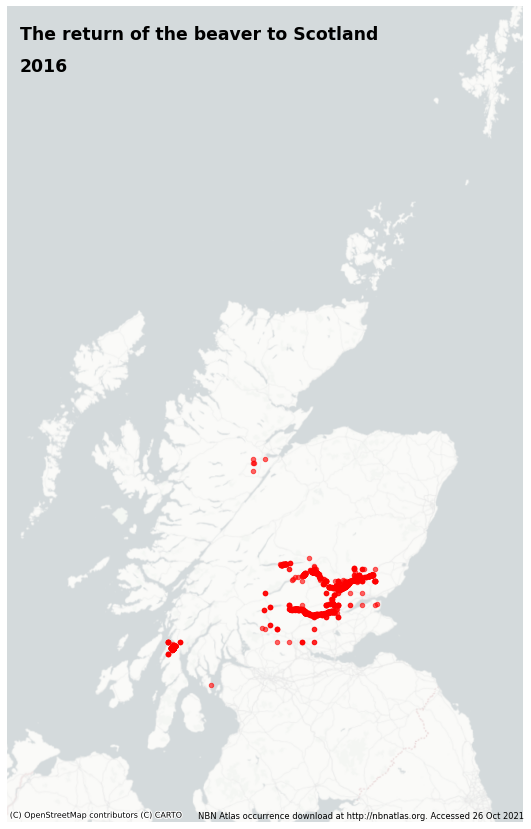

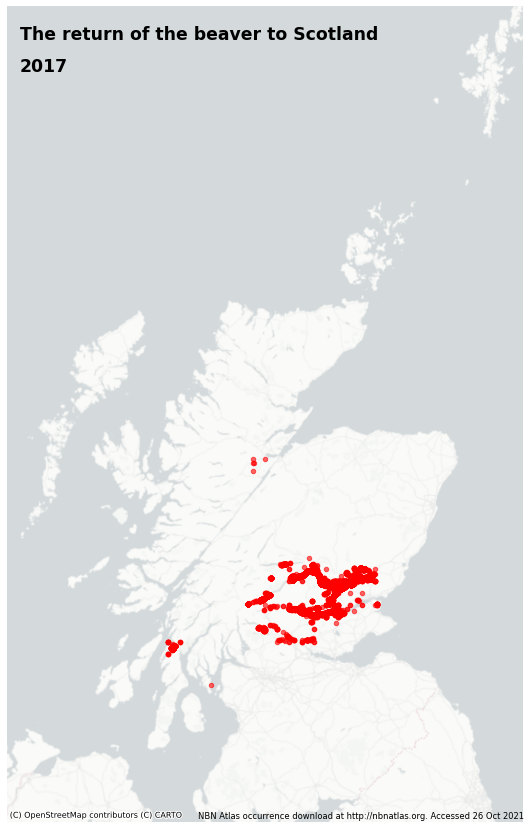

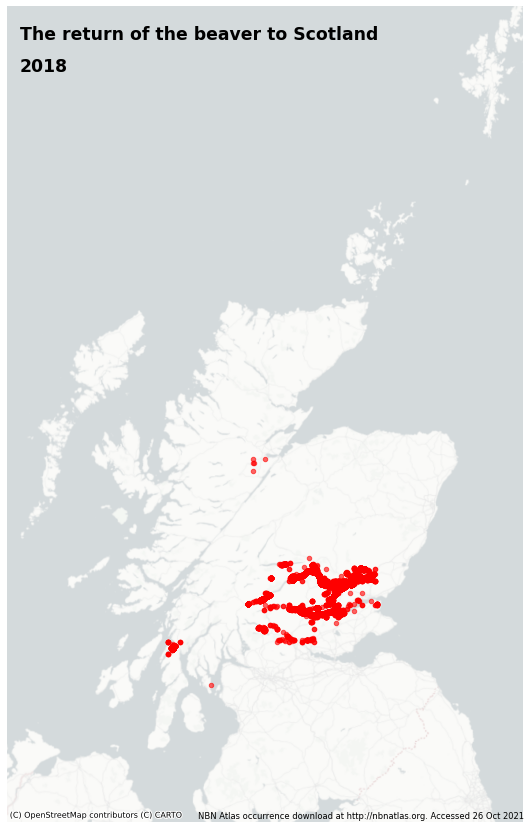

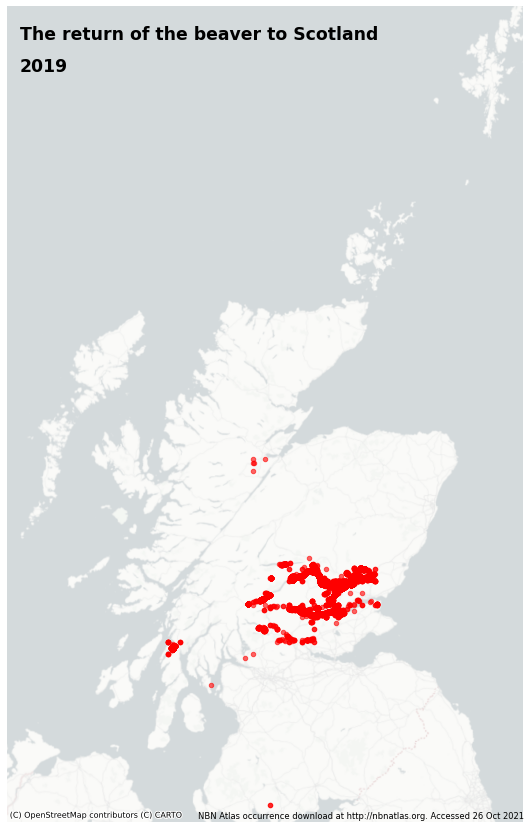

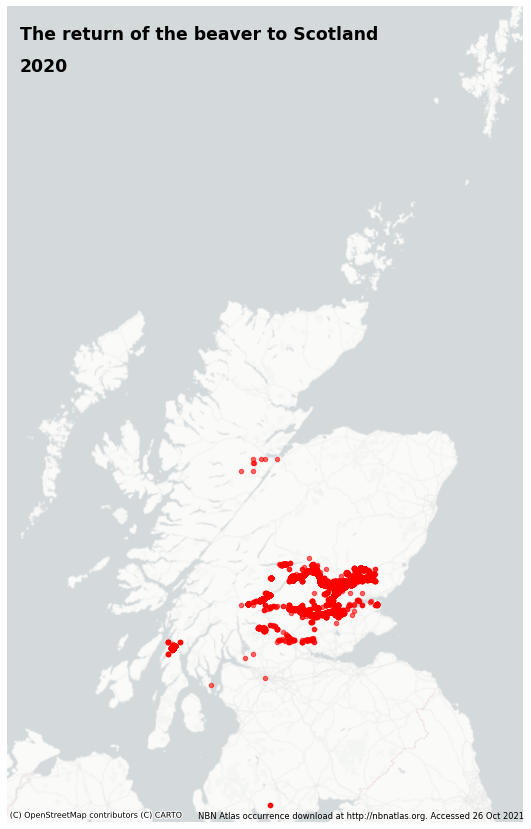

In [269]:
for i in range(2006,2021):
    fig, ax = plt.subplots(figsize=(15,15))
    gdf[gdf['year'] <= i].plot(
        color='red',
        alpha=0.6,
        marker='o', 
        markersize=20,
        ax=ax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_axis_off()
    ax.text(0.025, 
            0.96, 
            'The return of the beaver to Scotland', 
            transform=ax.transAxes, 
            fontsize='xx-large', 
            fontweight='bold', 
            fontfamily='sans-serif')
    ax.text(0.025, 
            0.92, 
            i, 
            transform=ax.transAxes, 
            fontsize='xx-large', 
            fontweight='bold', 
            fontfamily='sans-serif')
    ax.text(0.37, 
            0.005, 
            'NBN Atlas occurrence download at http://nbnatlas.org. Accessed 26 Oct 2021', 
            transform=ax.transAxes, 
            fontsize='small')
    cx.add_basemap(ax, 
                   crs=gdf.crs.to_string(), 
                   source=cx.providers.CartoDB.PositronNoLabels)
    plt.savefig(f'pngs/beaver_{str(i)}.png', 
                bbox_inches='tight', 
                dpi=200)

In [270]:
# convert png files to gif and save
png_dir = 'pngs/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(Image.open(file_path))
images[0].save('beaver_pil.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=750, loop=0)